In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vgg19, VGG19_Weights
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os


In [13]:
class AlgonautsDataset(Dataset):
    def __init__(self, parentDir: str, metaDataPath: str, subj: int, dataIdxs: list = None, transform = None):
        self.imagesPath = os.path.join(parentDir, f"subj0{subj}/training_split/training_images/")
        self.imagePaths = np.array(os.listdir(self.imagesPath))
        self.imageData = pd.read_pickle(os.path.join(metaDataPath, f"subj0{subj}ImgData.pkl"))["classLabel"]
        self.transform = transform
        if dataIdxs is not None:
            self.imagePaths = self.imagePaths[dataIdxs]
    def __len__(self):
        return len(self.imagePaths)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        imagePath = os.path.join(self.imagesPath, self.imagePaths[idx])
        image = Image.open(imagePath)
        label = self.imageData[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
mapFile = open("./imagenet2coco.txt", "r")
mapping = dict([tuple([line.split("\t")[1].split(",")[0], line.split("\t")[2]]) for line in mapFile.read().splitlines()])
mapFile.close()

In [9]:
mapping

{'tench': 'None',
 'goldfish': 'None',
 'great white shark': 'None',
 'tiger shark': 'None',
 'hammerhead': 'None',
 'electric ray': 'None',
 'stingray': 'None',
 'cock': 'None',
 'hen': 'bird',
 'ostrich': 'bird',
 'brambling': 'bird',
 'goldfinch': 'bird',
 'house finch': 'bird',
 'junco': 'bird',
 'indigo bunting': 'bird',
 'robin': 'bird',
 'bulbul': 'bird',
 'jay': 'person',
 'magpie': 'bird',
 'chickadee': 'bird',
 'water ouzel': 'bird',
 'kite': 'kite',
 'bald eagle': 'bird',
 'vulture': 'bird',
 'great grey owl': 'bird',
 'European fire salamander': 'None',
 'common newt': 'None',
 'eft': 'None',
 'spotted salamander': 'None',
 'axolotl': 'None',
 'bullfrog': 'None',
 'tree frog': 'None',
 'tailed frog': 'None',
 'loggerhead': 'None',
 'leatherback turtle': 'None',
 'mud turtle': 'None',
 'terrapin': 'None',
 'box turtle': 'None',
 'banded gecko': 'None',
 'common iguana': 'None',
 'American chameleon': 'None',
 'whiptail': 'None',
 'agama': 'None',
 'frilled lizard': 'None',
 

In [10]:
vggClasses = VGG19_Weights.IMAGENET1K_V1.meta["categories"]
otherClasses = list(mapping.keys())

#Check to see if there is any discrepancies in the labels used
for i in range(len(vggClasses)):
    word = otherClasses[i]
    if word != vggClasses[i]:
        print(f"{i} {word}")

In [11]:
tsfms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

In [14]:
dataDir = "../../algonauts_2023_challenge_data/"
metaDataPath = "../../subjCocoImgData/"
dataset = AlgonautsDataset(dataDir, metaDataPath, 1 , transform=tsfms)

In [17]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [20]:
device = "cuda:1"
model = vgg19(weights="DEFAULT").to(device)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [22]:
top5VggClasses = []

for data in dataloader:
    img, label = data
    img = img.to(device)

    with torch.no_grad():
        predictions = model(img)

    break

In [36]:
res = torch.topk(predictions, 5)

AttributeError: 'torch.return_types.topk' object has no attribute 'cpu'

In [39]:
mapIndices = lambda idx: mapping[vggClasses[idx]]

In [62]:
res = np.vectorize(mapIndices)(res.indices.cpu().numpy())

In [71]:
res

array([['None', 'None', 'None', 'None', 'None'],
       ['None', 'None', 'None', 'None', 'None'],
       ['None', 'kite', 'None', 'None', 'None'],
       ['dog', 'dog', 'dog', 'None', 'None'],
       ['None', 'bird', 'None', 'None', 'None'],
       ['None', 'None', 'None', 'None', 'None'],
       ['None', 'None', 'None', 'None', 'None'],
       ['None', 'None', 'None', 'None', 'None'],
       ['clock', 'clock', 'None', 'None', 'None'],
       ['None', 'None', 'None', 'None', 'None'],
       ['None', 'None', 'None', 'None', 'None'],
       ['None', 'None', 'None', 'None', 'None'],
       ['None', 'None', 'None', 'None', 'None'],
       ['microwave', 'None', 'None', 'None', 'toaster'],
       ['None', 'None', 'None', 'None', 'None'],
       ['None', 'None', 'apple', 'None', 'None'],
       ['None', 'traffic_light', 'None', 'person', 'None'],
       ['None', 'None', 'None', 'None', 'None'],
       ['None', 'None', 'None', 'None', 'None'],
       ['sandwich', 'None', 'None', 'None', 'None'

In [76]:
for i in res:
    hasValue = True
    for j in i:
        if j != "None":
            print(j)

kite
dog
dog
dog
bird
clock
clock
microwave
toaster
apple
traffic_light
person
sandwich
microwave
boat
bus
bus
car
truck
truck
elephant
elephant
bear
car
bus
truck
bus
car
traffic_light
boat
clock
cup
person
clock
elephant
elephant
sofa
bed
dog
bear
dog
dog
person
truck
truck
truck
person
bench
elephant
elephant
bottle
vase
truck
bus
bus
dog
dog
person
car
person
traffic_light
clock
bird
umbrella
elephant
elephant
laptop
bottle


In [51]:
dataset.__len__()

9841

In [59]:
testImg = dataset.__getitem__(9836)[0].to(device)
torch.topk(model(testImg[None, :, :, :]), 5)

torch.return_types.topk(
values=tensor([[11.7904, 11.1054,  9.6041,  8.9348,  8.9071]], device='cuda:1',
       grad_fn=<TopkBackward0>),
indices=tensor([[879, 669, 601, 562, 452]], device='cuda:1'))

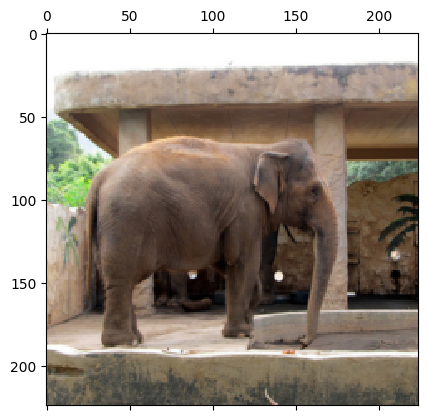

In [60]:
plt.matshow(dataset.__getitem__(59)[0].permute(1,2,0))